In [1]:
from Bio.PDB import PDBParser
from Bio.SeqUtils import seq1
from Bio import SeqIO
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import os
import re
from collections import Counter
from itertools import combinations
from collections import deque

In [2]:
def average_embedding(embedding_array, start, end):
    if start < 0 or end > len(embedding_array) or start >= end:
        raise ValueError("Invalid start or end for slicing.")
    return embedding_array[start:end].mean(axis=0)

#---

def similarity_matrix(emb1, emb2, window_size):
    L1, D1 = emb1.shape
    L2, D2 = emb2.shape
    if D1 != D2:
        raise ValueError("Embedding dimensions must match.")
    if window_size > min(L1, L2):
        raise ValueError("Window size too large for given sequences.")

    W1 = L1 - window_size + 1
    W2 = L2 - window_size + 1

    sim_matrix = np.zeros((W1, W2))

    # Precompute all windowed averages
    windows1 = [average_embedding(emb1, i, i + window_size) for i in range(W1)]
    windows2 = [average_embedding(emb2, j, j + window_size) for j in range(W2)]

    for i in range(W1):
        sims = cosine_similarity(windows1[i].reshape(1, -1), np.vstack(windows2)).flatten()
        sim_matrix[i, :] = sims

    best_i, best_j = np.unravel_index(np.argmax(sim_matrix), sim_matrix.shape)
    best_score = sim_matrix[best_i, best_j]
    return sim_matrix, (best_i, best_j, best_score)

#---

def plot_all_pair_similarities(df, embeddings_by_method, window_size=5):
    pair_list = []

    # Collect unique unordered pairs
    grouped = df.groupby('PAIR')
    for comparison_id, group in grouped:
        proteins = group['EMBEDDINGid'].unique()
        for id1, id2 in combinations(proteins, 2):
            pair_list.append((id1, id2, comparison_id))

    methods = list(embeddings_by_method.keys())
    nrows = len(pair_list)
    ncols = len(methods)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 3 * nrows))

    for row_idx, (id1, id2, comparison_id) in enumerate(pair_list):
        for col_idx, method in enumerate(methods):
            protein_embeddings = embeddings_by_method[method]

            try:
                emb1 = protein_embeddings[id1]
                emb2 = protein_embeddings[id2]
                sim_matrix, (best_emb1, best_emb2, best_score) = similarity_matrix(emb1, emb2, window_size)
            except ValueError as e:
                print(f"Skipping {id1}-{id2} due to error: {e}")
                continue

            ax = axes[row_idx, col_idx] if nrows > 1 else axes[col_idx]
            im = ax.imshow(sim_matrix, aspect='auto', cmap='viridis')
            ax.set_title(f"{id1} vs {id2}\n{method.upper()}", fontsize=8)
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    plt.show()

Sliding window

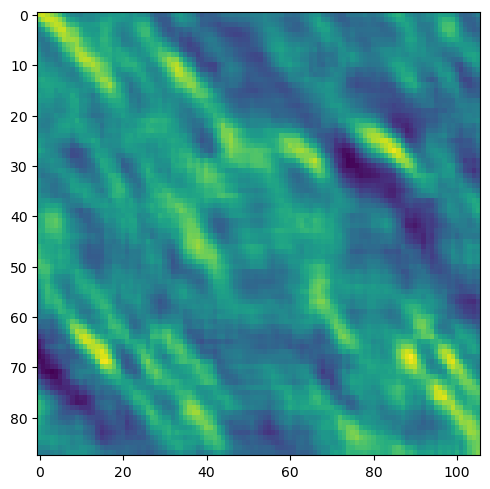

In [3]:
prott5_embs = pickle.load(open("../embeddings/residue_embs_prott5.pkl", "rb"))
window_size=5

emb1 = prott5_embs['d1slca__146']
emb2 = prott5_embs['d1sq9a__147']
sim_matrix, (best_emb1, best_emb2, best_score) = similarity_matrix(emb1,emb2,window_size)
plt.figure(figsize=(5, 5))  
plt.imshow(sim_matrix, aspect='auto', cmap='viridis')

plt.tight_layout()
plt.savefig("../images/d1slca_-d1sq9a_.png", dpi=500)
plt.show()

In [ ]:
embeddings_by_method = {
    'ProtT5': pickle.load(open("../embeddings/residue_embs_prott5.pkl", "rb")),
    'ESM2-3B': pickle.load(open("../embeddings/residue_embs_esm2_3B.pkl", "rb")),
    'ESM2-15B': pickle.load(open("../embeddings/residue_embs_esm2_15B.pkl", "rb")),
    'ESMC-6B': pickle.load(open("../embeddings/esmc-6b_aligned_results_safe.pkl", "rb")),
    'CARP': pickle.load(open("../embeddings/carp_aligned_results_safe.pkl", "rb"))
}

df = pd.read_csv("datasets/malisam_sequences_aligned.csv")
df["EMBEDDINGid"] = df["SCOPid"].astype(str) + '_' + df.index.astype(str)

plot_all_pair_similarities(df, embeddings_by_method, window_size=5)

ModuleNotFoundError: No module named 'torch'

In [ ]:
df = pd.read_csv("datasets/malisam_sequences_aligned.csv")
df["EMBEDDINGid"] = df["SCOPid"].astype(str) + '_' + df.index.astype(str)

protein_embeddings= {}

#with h5py.File(embedding_file, "r") as f:
with open('embeddings/residue_embs_esm2_3B.pkl', 'rb') as f:
    emb_dict = pickle.load(f)

for protein_id in df['EMBEDDINGid'].unique():
    if protein_id in emb_dict:
        protein_embeddings[protein_id] = emb_dict[protein_id][:]
    else:
        print(f"Warning: {protein_id} not found in the embedding file.")

window_sizes = [5, 10, 15, 20, 25, 30]

for w in window_sizes:
    print(f"Computing for window size: {w}")
    plot_all_pair_similarities(df, protein_embeddings, window_size=w, ncols=5)

GETTING ALINGMENTS FROM MATRIX

In [ ]:
#Aligned residues comparison

embeddings_by_method = {
#    'prott5': pickle.load(open("embeddings/residue_embs_prott5.pkl", "rb"))
#    'esm2_3B': pickle.load(open("embeddings/residue_embs_esm2_3B.pkl", "rb"))
#    'esm_15B': pickle.load(open("embeddings/residue_embs_esm2_15B.pkl", "rb"))
#    'carp': pickle.load(open("embeddings/carp_aligned_results_safe.pkl", "rb"))
#    'prosst5': pickle.load(open("embeddings/prostt5_aligned_embs_safe.pkl", "rb"))
}

embeddings_by_method = {
    'carp': pickle.load(open("embeddings/carp_aligned_results_safe.pkl", "rb"))
}

df = pd.read_csv("malisam_sequences/malisam_sequences_aligned.csv")
df["EMBEDDINGid"] = df["SCOPid"].astype(str) + '_' + df.index.astype(str) 

matrix_dict = {}
for comparison_id, group in df.groupby('PAIR'):
    ids = group['EMBEDDINGid'].drop_duplicates().tolist()
    for id1, id2 in combinations(ids, 2):
        if id1 == id2:
            continue

        for method, protein_embeddings in embeddings_by_method.items():
            try:
                emb1 = protein_embeddings[id1]
                emb2 = protein_embeddings[id2]
                seq_length1 = emb1.shape[0]
                seq_length2 = emb2.shape[0]

                sim_matrix, _ = similarity_matrix(emb1, emb2, 1)

                matrix_dict[comparison_id] = sim_matrix
            except:
                matrix_dict[comparison_id] = None

with open("carp_aligned_matrix_data_5.pkl", "wb") as f:
    pickle.dump(matrix_dict, f)
matrix_dict


{'d1a05a_d1dgsa3': array([[0.97969335, 0.96265376, 0.96399325, ..., 0.96958792, 0.96989757,
         0.97545081],
        [0.96901697, 0.97955453, 0.98209572, ..., 0.98853207, 0.98613054,
         0.9919647 ],
        [0.96702683, 0.97520828, 0.97980195, ..., 0.9873324 , 0.98519409,
         0.98621702],
        ...,
        [0.96637344, 0.97788358, 0.97700542, ..., 0.98866063, 0.98565412,
         0.98720628],
        [0.96587366, 0.9762845 , 0.97579569, ..., 0.98812342, 0.98480397,
         0.98702711],
        [0.96411991, 0.97666591, 0.97496599, ..., 0.98656297, 0.98257303,
         0.98564667]]),
 'd1a05a_d1j71a_': array([[0.96429765, 0.95651126, 0.95829731, ..., 0.9356851 , 0.939753  ,
         0.94868797],
        [0.96232182, 0.96750051, 0.96973199, ..., 0.94925702, 0.954772  ,
         0.95234144],
        [0.95956403, 0.96607012, 0.9680028 , ..., 0.9475435 , 0.96262085,
         0.94963282],
        ...,
        [0.96391624, 0.96887028, 0.9700771 , ..., 0.9466238 , 0.95354599

In [ ]:
#Full sequence comparison

def pdb_root(x):
    s = x.strip()
    s = re.sub(r'^pdb:', '', s, flags=re.I)       
    s = s.replace('.', '_')                       
    m = re.search(r'([0-9][A-Za-z0-9]{3})', s)
    return m.group(1).lower() if m else s.lower()

data_name = 'prostt5_aligned_matrix_data'
protein_embeddings = pickle.load(open("embeddings/prostt5_aligned_embs_safe.pkl", "rb"))

df = pd.read_csv("malisam_sequences/malisam_complete_sequences_aligned.csv")
df["EMBEDDINGid"] = df["SCOPid"].astype(str) + '-' + df["CHAIN"].astype(str) + '_' + df.index.astype(str)

window_list = [5]
for window in window_list:
    matrix_dict = {}
    for comparison_id, group in df.groupby('PAIR'):
        entities = (
            group[['EMBEDDINGid', 'CHAIN']]
            .drop_duplicates()
            .itertuples(index=False, name=None)  
        )
        for (id1, ch1), (id2, ch2) in combinations(entities, 2):
            if id1 == id2:
                continue
            
            if pdb_root(id1) == pdb_root(id2):
                continue

            emb1 = protein_embeddings[id1]
            emb2 = protein_embeddings[id2]
            seq_length1 = emb1.shape[0]
            seq_length2 = emb2.shape[0]

            sim_matrix, _ = similarity_matrix(emb1, emb2, window)

            matrix_dict[id1+'-'+id2] = sim_matrix

    with open(f"{data_name}_{window}.pkl", "wb") as f:
        pickle.dump(matrix_dict, f)
    matrix_dict